# HW 11.

* Running the models may take minutes. This HW takes ~30 min to complete in computational time, so make sure you don't start it 1 hour before it is due.

* Tasks 2-4. should be done using the `sklearn` library, the last is a pure TensorFlow ([Keras is part of TensorFlow](https://github.com/keras-team/keras/releases#:~:text=since%20this%20release-,Keras%202.2.,well%20as%20Theano%20and%20CNTK)) example.

  * Use tf.keras instead of the standalone keras package

* The example notebook was run in Google COLAB without any package installation. I advise you to use Google COLAB with a GPU instance for the last task.

* Where not asked otherwise, use the default settings for the model.

* You may try running the models using more CPU cores to speed the training (sklearn supports for most of the models with a parameter, usually n_jobs).

### Compatibility notes

I've used TensorFlow's nightly builds `2.5.0-dev20201127` and `2.5.0-dev20201128` with `CUDA 11.0_2` and `cuDNN 8.0.5` support on my own computer's GPU.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.gridspec as gridspec

from IPython.display import display

In [4]:
from hw_utils import *

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib

import tensorflow.keras.callbacks as kc

import sklearn
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [6]:
print(tf.__version__)

2.5.0-dev20201128


In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4761919042754341018,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5060693856
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12569248885930238483
 physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [10]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [11]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')
rocket_cmap = sns.color_palette('rocket', as_cmap=True)

target_colors = np.array([cm.magma(0.5), cm.magma(0.75), cm.magma(0.93)])
feature_colors = np.array([rocket_cmap(0.17), cm.magma(0.45), cm.magma(0.60), cm.magma(0.75)])

## 1. Load the CIFAR 10 dataset from the `tf.keras.datasets` API and train a `LogisticRegression` model on the dataset and predict all test outcomes with the `sklearn` API

* Create an image grid visualization of randomly selected images (9, 16) with labels.
* Preprocess the dataset for `sklearn`, scale the pixels [0-1], and also flatten each example to a vector.
* Use the `multi_class='multinomial'` option, describe what it means.
* Plot the ROC curves and AUC scores on the same figure for each class.
* Calculate the accuracy of the classifier on the test set.

Hint:
* `from sklearn.preprocessing import LabelBinarizer` might be useful for you.

### 1./a. Load and preprocess the CIFAR10 dataset

In [12]:
# Load CIFAR 10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [13]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)


#### Look at some random images

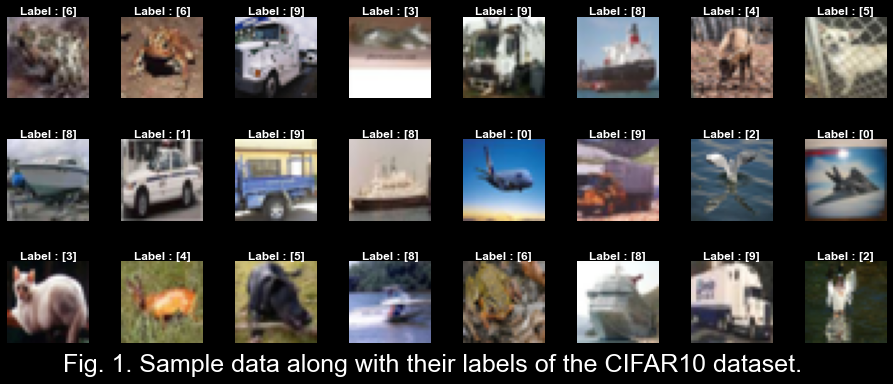

In [14]:
nrows = 3
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
fig.subplots_adjust(hspace=0.5)

rand_idx = np.random.randint(0, len(X_train), size=nrows*ncols)
images = X_train[rand_idx]
labels = y_train[rand_idx]

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(images[i], cmap='Greys_r')
    ax.set_title('Label : {0}'.format(labels[i]), fontweight='bold',
                 color='white', pad=0)
    ax.axis('off')
    ax.grid(False)

plt.suptitle('Fig. 1. Sample data along with their labels of the CIFAR10 dataset.',
             color='white', fontsize=axistitlesize+5, y=0.1)
    
plt.show()

#### Scale and flatten

In [15]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32*32*3))
X_test = X_test.reshape((-1, 32*32*3))
# Reshape labels to shape of (n_samples, )
y_train = y_train.reshape(y_train.size, )
y_test = y_test.reshape(y_test.size, )

In [16]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 3072)
y_train shape : (50000,)
X_test shape : (10000, 3072)
y_test shape : (10000,)


### 1./b. Fit logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
## DEFINE LOGISTIC-REGRESSION
# The meaning of the `multi_class` argument set to 'multinomial' is
# explaned in the docstring of the `LogisticRegression` function:
# > "For 'multinomial' the loss minimised is the multinomial loss fit
# > across the entire probability distribution, *even when the data is
# > binary*."
model_ex1 = LogisticRegression(penalty='l2', C=1.0, multi_class='multinomial',
                               max_iter=10000)

In [26]:
%%time
# Fit model
model_ex1.fit(X_train, y_train)

Wall time: 15min 18s


LogisticRegression(max_iter=10000, multi_class='multinomial')

#### Pickling
- Save models if all of them were fitted
- Load models if there is a saved instance of them

In [27]:
pickle_file = './models/saved_models_ex1'
with open(pickle_file, 'wb') as f:
    pickle.dump(model_ex1, f)
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        model_ex1 = pickle.load(f)

### 1./c. Make predictions with the model

In [28]:
y_pred = model_ex1.predict(X_test)

In [29]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,10)])

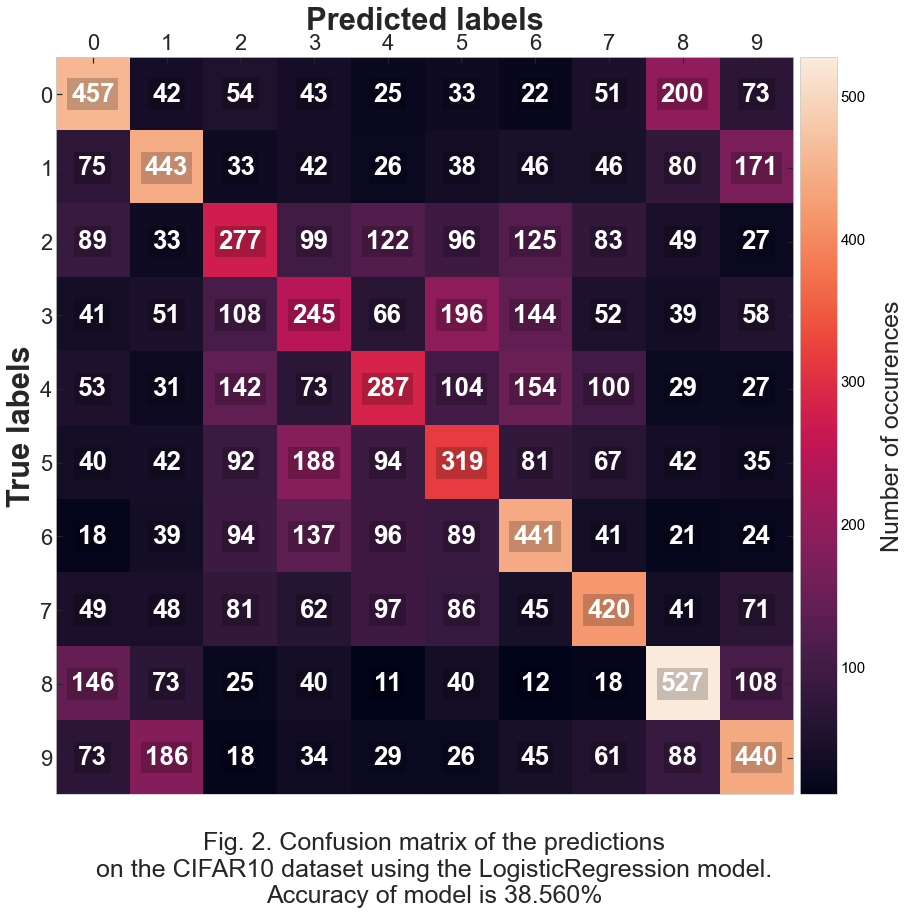

In [30]:
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,10)],
                      title=('Fig. 2. Confusion matrix of the predictions\n' +
                             'on the CIFAR10 dataset using the LogisticRegression model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

#### ROC curve

In [31]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(model_ex1, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(model_ex1, X_test, y_test)

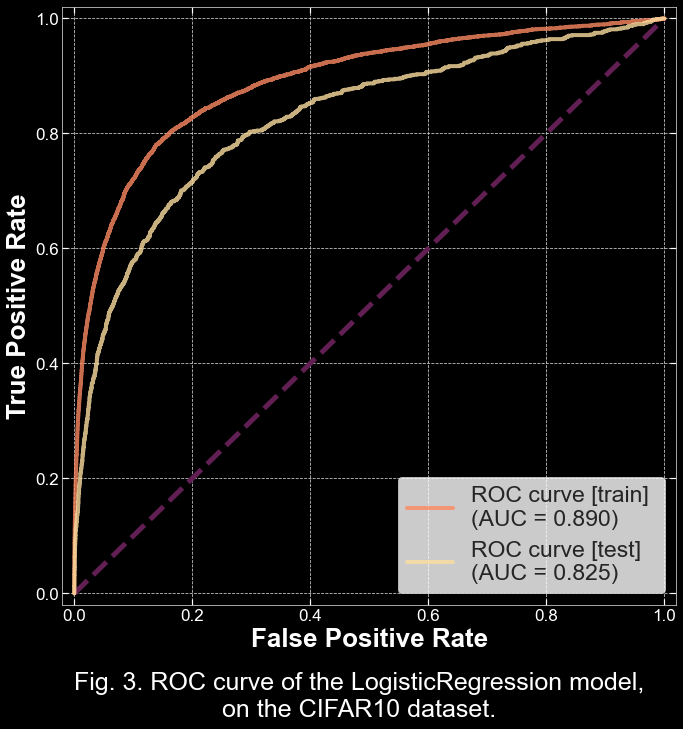

In [32]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 3. ROC curve of the LogisticRegression model,\n' +
             'on the CIFAR10 dataset.',
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

## 2. Train an `SGDClassifier` regression model on the dataset and predict all the test outcomes with the `sklearn` API. 

* Select an appropiate loss for this task, explain what this means.
* Time is precious, run the classifier paralell on many jobs.
* Plot the ROC curves and AUC scores on the same figure for the test set.
* Calculate the accuracy of the classifier.
* Describe the above model with your own words, how is it different than the logistic regression model?

### 2./a. Load and preprocess the CIFAR10 dataset

In [33]:
# Load CIFAR 10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [34]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)


#### Scale and flatten

In [35]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32*32*3))
X_test = X_test.reshape((-1, 32*32*3))
# Reshape labels to shape of (n_samples, )
y_train = y_train.reshape(y_train.size, )
y_test = y_test.reshape(y_test.size, )

In [36]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 3072)
y_train shape : (50000,)
X_test shape : (10000, 3072)
y_test shape : (10000,)


### 2./b. Fit SGDClassifier

In [37]:
from sklearn.linear_model import SGDClassifier

In [38]:
_losses = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
saved_models = {}

In [39]:
## DEFINE SGD-CLASSIFIER
#
# 1. ABOUT LOSS:
# The documentation say the following abot (classification) losses:
# > [...]
# > The possible options are 'hinge', 'log', 'modified_huber',
# > 'squared_hinge', 'perceptron' [...]
#
# > The 'log' loss gives logistic regression, a probabilistic classifier.
# > 'modified_huber' is another smooth loss that brings tolerance to
# > outliers as well as probability estimates.
# > 'squared_hinge' is like hinge but is quadratically penalized.
# > 'perceptron' is the linear loss used by the perceptron algorithm.
# > [...]
loss = _losses[4]
penalty = 'l2'
model_ex2 = SGDClassifier(loss=loss,
                          penalty=penalty,
                          alpha=0.0001,
                          l1_ratio=0.15,
                          fit_intercept=True,
                          max_iter=10000,
                          tol=0.001,
                          shuffle=True,
                          epsilon=0.1,
                          n_jobs=-1,
                          random_state=42,
                          learning_rate='optimal',
                          validation_fraction=0.2,
                         )

In [67]:
%%time
# Fit model
model_ex2.fit(X_train, y_train)
saved_models[loss] = model_ex2

Wall time: 1min 52s


#### Pickling
- Save models if all of them were fitted
- Load models if there is a saved instance of them

In [41]:
pickle_file = './models/saved_models_ex2'
if len(saved_models) == len(_losses):
    with open(pickle_file, 'wb') as f:
        pickle.dump(saved_models, f)
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        saved_models = pickle.load(f)

### 2./c. Make predictions with the model

In [43]:
# Load specific model
loss = _losses[0]
model = saved_models[loss]

In [44]:
y_pred = model.predict(X_test)

In [45]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,10)])

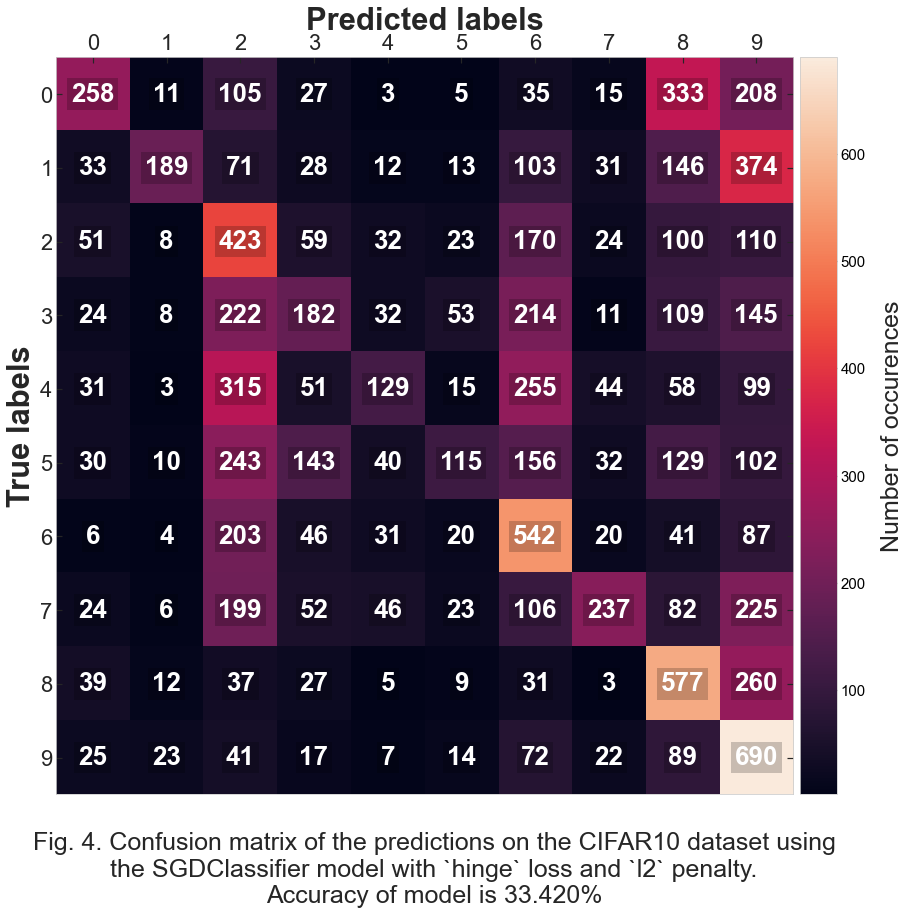

In [46]:
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,10)],
                      title=('Fig. 4. Confusion matrix of the predictions on the CIFAR10 dataset using\n' +
                             'the SGDClassifier model with `{0}` loss and `{1}` penalty.\n'.format(loss, penalty) +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

#### ROC curve

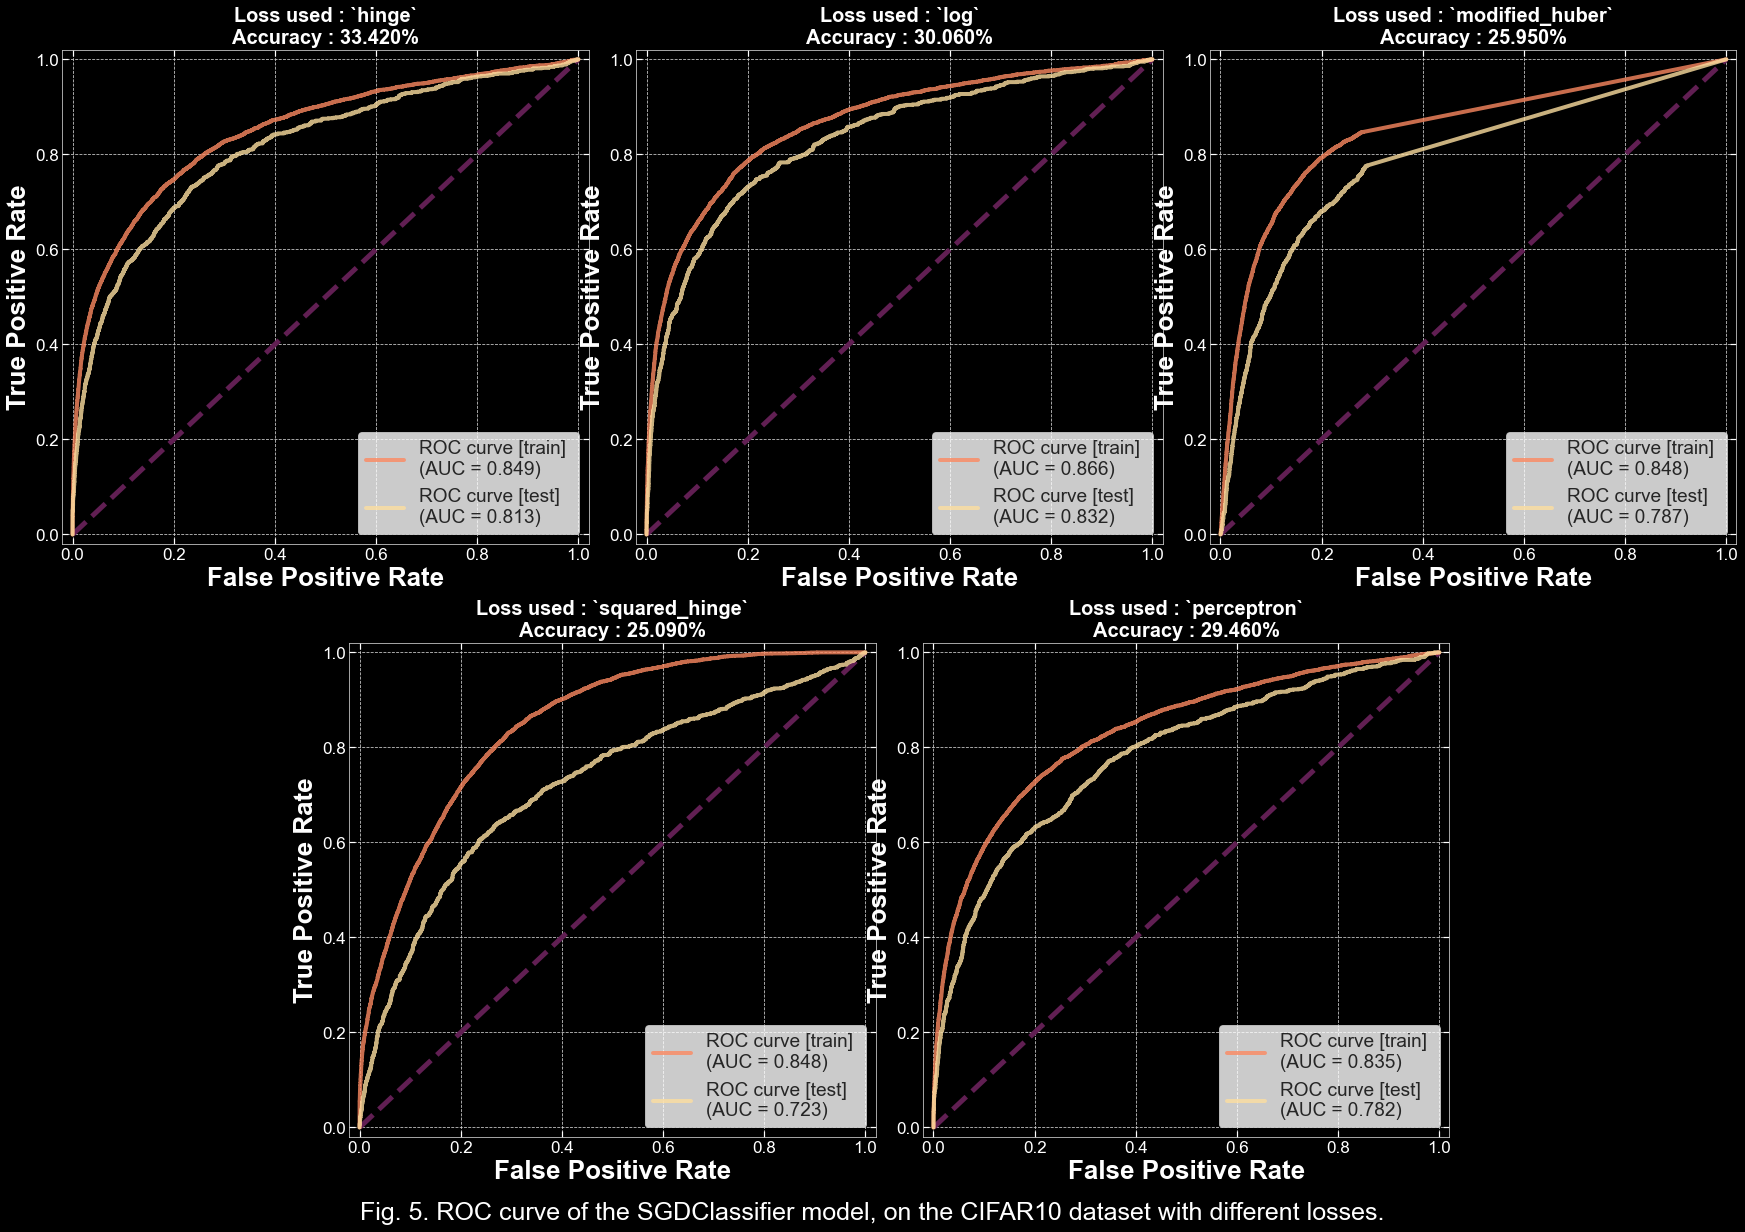

In [47]:
plt.figure(figsize=(10*3,10*2),
           facecolor='black')
gs = gridspec.GridSpec(2, 6)
gs.update(hspace=0.2, wspace=0.2)

ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:6])
ax4 = plt.subplot(gs[1, 1:3])
ax5 = plt.subplot(gs[1, 3:5])
axes = [ax1, ax2, ax3, ax4, ax5]

for i, ax in enumerate(axes):
    ax.set_facecolor('black')
    ax.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

    # Current model
    model = saved_models[_losses[i]]
    
    # Calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
    
    # Calculate ROC and AUC
    fpr_tr, tpr_tr, roc_auc_tr = compute_roc(model, X_train, y_train)
    fpr_ts, tpr_ts, roc_auc_ts = compute_roc(model, X_test, y_test)
    
    # My model
    ax.plot(fpr_tr, tpr_tr,
            label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
            color=cm.magma(0.75), lw=4, alpha=0.8)
    ax.plot(fpr_ts, tpr_ts,
            label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
            color=cm.magma(0.93), lw=4, alpha=0.8)

    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])

    ax.set_title('Loss used : `{}`\n'.format(_losses[i]) +
                 'Accuracy : {:.3f}%'.format(accuracy),
                 fontsize=axistitlesize, fontweight='bold', color='white')
    ax.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

    ax.legend(loc='lower right', fontsize=axislegendsize-4)

plt.suptitle('Fig. 5. ROC curve of the SGDClassifier model, on the CIFAR10 dataset with different losses.',
             fontsize=axistitlesize+5, y=0.08, color='white')
    
plt.show()

It seems, that the best choice of loss for the `SGDClassifier` is its default, `hingle` loss.

## 3. Train a RandomForest classifier

* Plot the ROC curve with AUC scores on the test set.
* Calculate accuracy of the classifier on the test set.

### 3./a. Load and preprocess the CIFAR10 dataset

In [48]:
# Load CIFAR 10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [49]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)


#### Scale and flatten

In [50]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32*32*3))
X_test = X_test.reshape((-1, 32*32*3))
# Reshape labels to shape of (n_samples, )
y_train = y_train.reshape(y_train.size, )
y_test = y_test.reshape(y_test.size, )

In [51]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 3072)
y_train shape : (50000,)
X_test shape : (10000, 3072)
y_test shape : (10000,)


### 3./b. Fit RandomForestClassifier

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
## DEFINE RANDOM-FOREST-CLASSIFIER
model_ex3 = RandomForestClassifier(n_estimators=100,
                                   criterion='gini',
                                   max_depth=30,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.0,
                                   max_features='auto',
                                   max_leaf_nodes=None,
                                   min_impurity_decrease=0.0,
                                   min_impurity_split=None,
                                   bootstrap=True,
                                   oob_score=False,
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=0,
                                   warm_start=False,
                                   class_weight=None,
                                   ccp_alpha=0.0,
                                   max_samples=None
                                  )

In [56]:
%%time
model_ex3.fit(X_train, y_train)

Wall time: 1min


RandomForestClassifier(max_depth=30, n_jobs=-1, random_state=42)

In [57]:
pickle_file = './models/saved_models_ex3'
with open(pickle_file, 'wb') as f:
    pickle.dump(model_ex3, f)
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        model_ex3 = pickle.load(f)

### 3./c. Make predictions with the model

In [58]:
y_pred = model_ex3.predict(X_test)

In [59]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,10)])

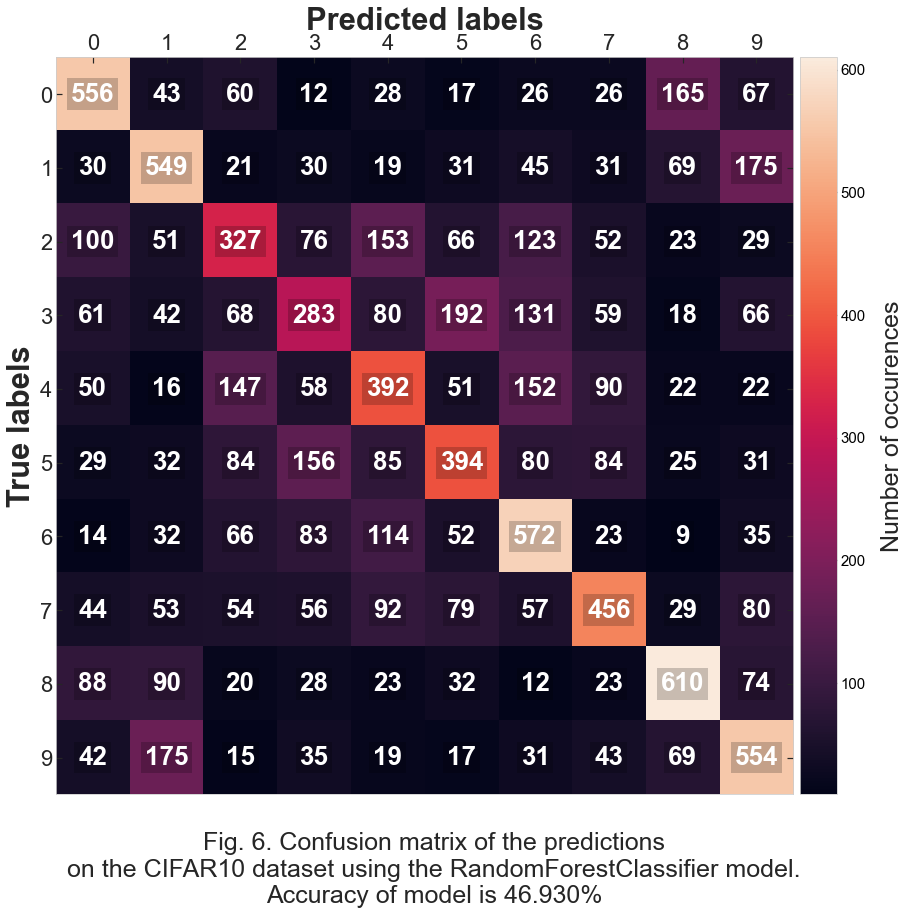

In [60]:
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,10)],
                      title=('Fig. 6. Confusion matrix of the predictions\n' +
                             'on the CIFAR10 dataset using the RandomForestClassifier model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

#### ROC curve

In [61]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(model_ex3, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(model_ex3, X_test, y_test)

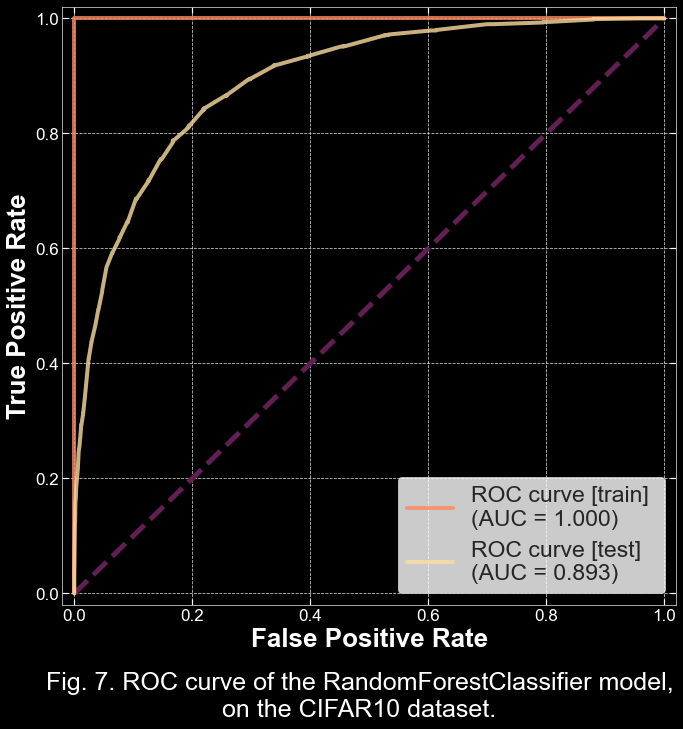

In [62]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 7. ROC curve of the RandomForestClassifier model,\n' +
             'on the CIFAR10 dataset.',
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

## 4. Train an multi layer perceptron classifier

* use the `MLPClassifier` from `sklearn`
* Set its parameter to `max_iter = 30` or if you have time, set it for at least `100`. After `30` iterations the model does not converge but gives reasonable predictions (with default parameters).
* Plot the ROC curves with AUC scores for the test set.
* Calculate the accuracy of the model on the test set.

### 4./a. Load and preprocess the CIFAR10 dataset

In [63]:
# Load CIFAR 10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [64]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)


#### Scale and flatten

In [65]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32*32*3))
X_test = X_test.reshape((-1, 32*32*3))
# Reshape labels to shape of (n_samples, )
y_train = y_train.reshape(y_train.size, )
y_test = y_test.reshape(y_test.size, )

In [66]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 3072)
y_train shape : (50000,)
X_test shape : (10000, 3072)
y_test shape : (10000,)


### 4./b. Fit MLPClassifier

In [67]:
from sklearn.neural_network import MLPClassifier

In [68]:
## DEFINE MLP-CLASSIFIER
# - max_iter set to its default : 200
model_ex4 = MLPClassifier(hidden_layer_sizes=(100,),
                          activation='relu',
                          solver='adam',
                          alpha=0.0001,
                          batch_size='auto',
                          learning_rate='constant',
                          learning_rate_init=0.001,
                          power_t=0.5,
                          max_iter=200,
                          shuffle=True,
                          random_state=42,
                          tol=0.0001,
                          verbose=False,
                          warm_start=False,
                          momentum=0.9,
                          nesterovs_momentum=True,
                          early_stopping=False,
                          validation_fraction=0.1,
                          beta_1=0.9,
                          beta_2=0.999,
                          epsilon=1e-08,
                          n_iter_no_change=10,
                          max_fun=15000
                         )

In [145]:
%%time
# Only run if necessary
# My runtime was: 1h 23min 45s
#model_ex4.fit(X_train, y_train)

Wall time: 1h 23min 45s


C:\ProgramData\Miniconda3\envs\tf2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [71]:
pickle_file = './models/saved_models_ex4'
#with open(pickle_file, 'wb') as f:
#    pickle.dump(model_ex4, f)
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        model_ex4 = pickle.load(f)

### 4./c. Make predictions with the model

In [72]:
y_pred = model_ex4.predict(X_test)

In [73]:
# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels=[i for i in range(0,10)])

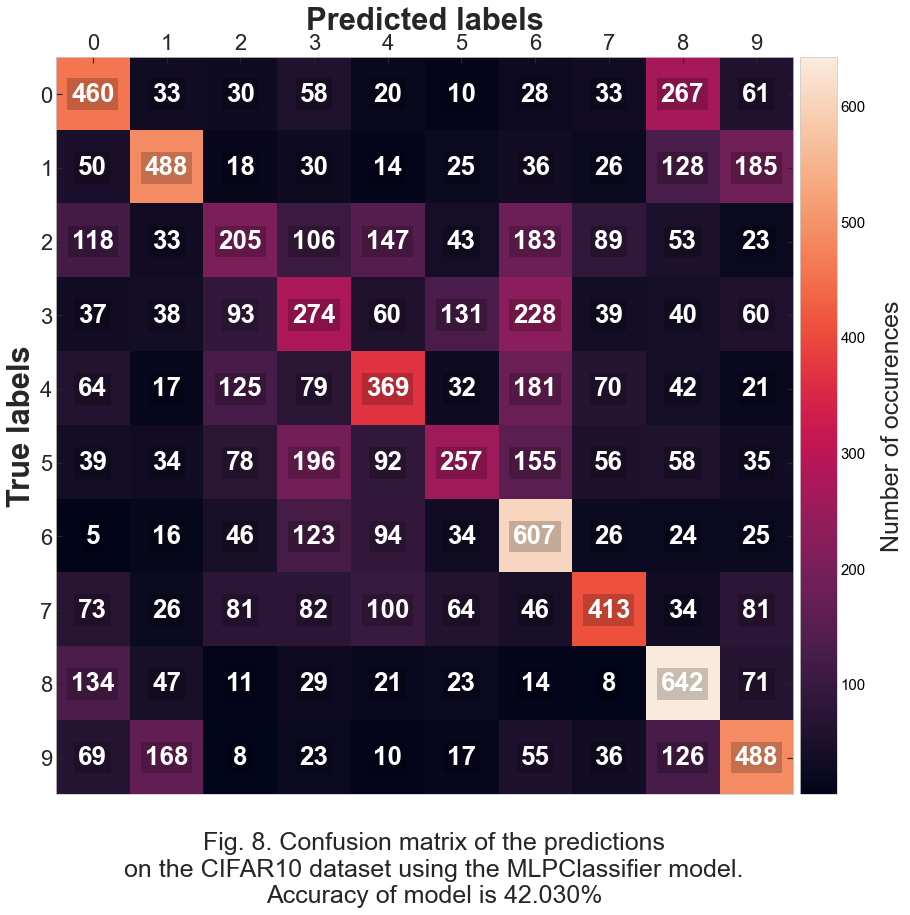

In [74]:
plot_confusion_matrix(conf_mat, y_test, labels=[i for i in range(0,10)],
                      title=('Fig. 8. Confusion matrix of the predictions\n' +
                             'on the CIFAR10 dataset using the MLPClassifier model.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

#### ROC curve

In [75]:
fpr_tr, tpr_tr, roc_auc_tr = compute_roc(model_ex4, X_train, y_train)
fpr_ts, tpr_ts, roc_auc_ts = compute_roc(model_ex4, X_test, y_test)

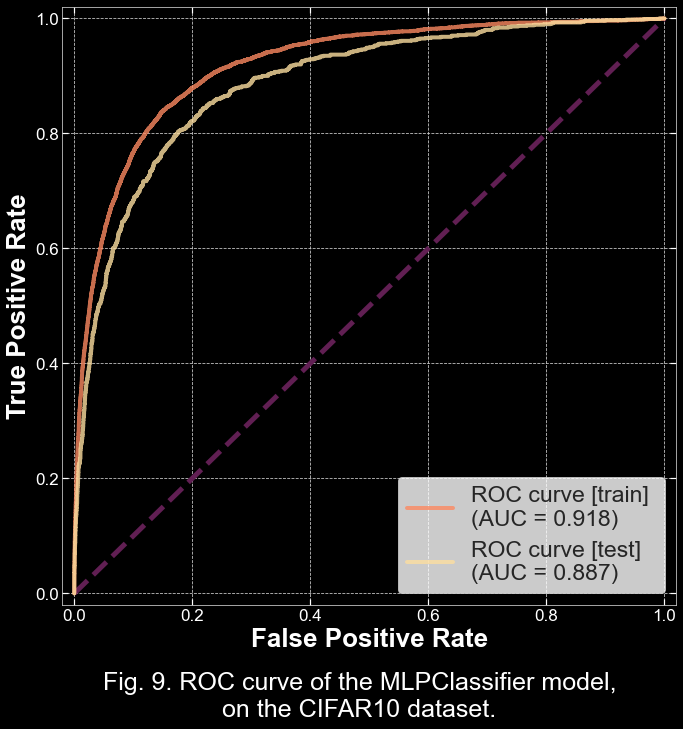

In [76]:
fig, axes = plt.subplots(figsize=(11, 11),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

axes.plot([0, 1], [0, 1], color=rocket_cmap(0.25), lw=5, linestyle='--')

# My model
axes.plot(fpr_tr, tpr_tr,
          label='ROC curve [train] \n(AUC = %0.3f)' % roc_auc_tr,
          color=cm.magma(0.75), lw=4, alpha=0.8)
axes.plot(fpr_ts, tpr_ts,
          label='ROC curve [test] \n(AUC = %0.3f)' % roc_auc_ts,
          color=cm.magma(0.93), lw=4, alpha=0.8)

axes.set_xlim([-0.02, 1.02])
axes.set_ylim([-0.02, 1.02])

axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, colors='white')

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 9. ROC curve of the MLPClassifier model,\n' +
             'on the CIFAR10 dataset.',
             fontsize=axistitlesize+5, y=0.04, color='white')
    
plt.show()

## 5. Train a ResNet50 CNN model on the dataset, utilize ImageNet pre-trained weights and fine-tune for at least 3 epochs:

* training for 3 epochs should be enough to prove that this model is superior compared to others, train longer to explore the possibilities of the model

Convert the dataset:

```python
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(32)
```

Hints:

* loading a pretrained model and letting its parameters be tunable

```python
backbone = tf.keras.applications.YOUR_MODEL_OF_CHOICE # set include_top = False to get rid of the dense layers
backbone.trainable = True # set if you want to fine-tune the pretrained weights too, otherwise set to False
```

* defining your custom model with the pretrained backbone

```python
# YOUR_MODEL_OF_CHOICE here is ResNet50 as per the task description.

# Functional TensorFlow API
def my_own_model():
  inp = tf.keras.layers.Input(shape=(32, 32, 3))
  x = tf.keras.applications.YOUR_MODEL_OF_CHOICE.preprocess_input(inp)

  x = backbone(x)
  # Here comes some more layers
  # and flattening where needed!
  out = # layer outputting the specified number of classes
        # with or without a softmax activation, later on
        # the choice of the loss depends on this
  model = tf.keras.models.Model(inputs=inp, outputs=out)
  return model
```

### 5./a. Load and preprocess dataset

In [153]:
# Load CIFAR 10 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [154]:
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1)


In [155]:
# Scale data
X_train = X_train / 255
X_test = X_test / 255
# Reshape data
X_train = X_train.reshape((-1, 32,32, 3))
X_test = X_test.reshape((-1, 32,32, 3))
# Convert labels to one-hot encoded arrays
y_train = label_binarize(y_train, classes=np.unique(y_train)).reshape(-1, 1, 1, 10)
y_test = label_binarize(y_test, classes=np.unique(y_test)).reshape(-1, 1, 1, 10)

In [156]:
print('X limits :', X_train.min(), '-', X_train.max())
print('X_train shape :', X_train.shape)
print('y_train shape :', y_train.shape)
print('X_test shape :', X_test.shape)
print('y_test shape :', y_test.shape)

X limits : 0.0 - 1.0
X_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1, 1, 10)
X_test shape : (10000, 32, 32, 3)
y_test shape : (10000, 1, 1, 10)


### 5./b. Train custom model for 3 epochs long

In [157]:
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr

In [173]:
def best_model(imsize, n_channels=1, n_class=10,
               model_name='default_model'):
    """
    Creating a model based on the advice of task 5 in homework 11.
    
    Parameters
    ----------
    imsize : int
        Side length of the square-shaped input image in pixels.
    n_channels : int
        Number of color/other channels of the input images.
    n_class : int
        Number of classes in the classification problem.

    Returns
    -------
    model : tensorflow.python.keras.engine.training.Model
        The constructed, yet unconfigured CNN model.
    """
    # Tensorflow placeholder for inputs
    inp = kl.Input(shape=(imsize, imsize, n_channels),
                   name='input_ex5')

    # Define a model for the backbone of the net
    # Here it's ResNet50 with loaded ImageNet weights
    model = tf.keras.applications.ResNet50(include_top=False,
                                           input_tensor=inp, weights='imagenet')
    model.trainable = True
    
    # Preprocess the input first
    x = tf.keras.applications.resnet50.preprocess_input(inp)
    
    # Run through the backbone the preprocessed input
    x = model(inp)
    
    # Final flatten FC
    out = kl.Dense(units=n_class,
                   activation='softmax',
                   name='final_dense_ex5')(x)

    # Define model
    model = km.Model(inputs=inp, outputs=out,
                     name=model_name)

    # Multi GPU model
    #if(len(gpu.split(',')) > 1):
    #    model = multi_gpu_model(model, gpus=len(gpu.split(',')))

    return model

In [199]:
with tf.device('/device:GPU:0'):
    # Create checkpoint file to save best model into
    okay_model_ex5 = kc.ModelCheckpoint('./models/okay_model_ex5.hdf5', save_best_only=True, verbose=1)
    # Configure early stopping with N epochs of patience
    es_ex5 = kc.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    
    # Define the model
    model_ex5 = best_model(imsize=32, n_channels=3, n_class=10,
                           model_name='model_ex5')
    
    # Configure the model
    model_ex5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
                      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                      metrics=['accuracy'])

In [200]:
model_ex5.summary()

Model: "model_ex5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ex5 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
final_dense_ex5 (Dense)      (None, 1, 1, 10)          20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [201]:
epochs_ex5 = 3

In [202]:
with tf.device('/device:GPU:0'):
    history_ex5 = model_ex5.fit(x=X_train,
                                y=y_train,
                                batch_size=32,
                                epochs=epochs_ex5,
                                verbose=1,
                                validation_split=0.2,
                                shuffle=True,
                                callbacks=[es_ex5, okay_model_ex5],
                                initial_epoch=0,
                                steps_per_epoch=None)

Epoch 1/3
1250/1250 [==============================] - 98s 73ms/step - loss: 3.3145 - accuracy: 0.1595 - val_loss: 14.2882 - val_accuracy: 0.1501

Epoch 00001: val_loss improved from inf to 14.28818, saving model to ./models\best_model_ex5.hdf5
Epoch 2/3
1250/1250 [==============================] - 89s 71ms/step - loss: 2.0880 - accuracy: 0.2687 - val_loss: 6.0614 - val_accuracy: 0.1294

Epoch 00002: val_loss improved from 14.28818 to 6.06136, saving model to ./models\best_model_ex5.hdf5
Epoch 3/3
1250/1250 [==============================] - 89s 71ms/step - loss: 1.7205 - accuracy: 0.3601 - val_loss: 1.8888 - val_accuracy: 0.3721

Epoch 00003: val_loss improved from 6.06136 to 1.88877, saving model to ./models\best_model_ex5.hdf5


### 5./c. Make predictions with the model

In [203]:
y_pred = model_ex5.predict(X_test)

In [204]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_b = y_test.reshape(-1, 10)
y_pred_b = y_pred.reshape(-1, 10)
y_test_b = y_test_b.argmax(axis=-1)
y_pred_b = y_pred_b.argmax(axis=-1)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_b, y_pred=y_pred_b)
conf_mat = confusion_matrix(y_test_b, y_pred_b, labels=[i for i in range(0,10)])

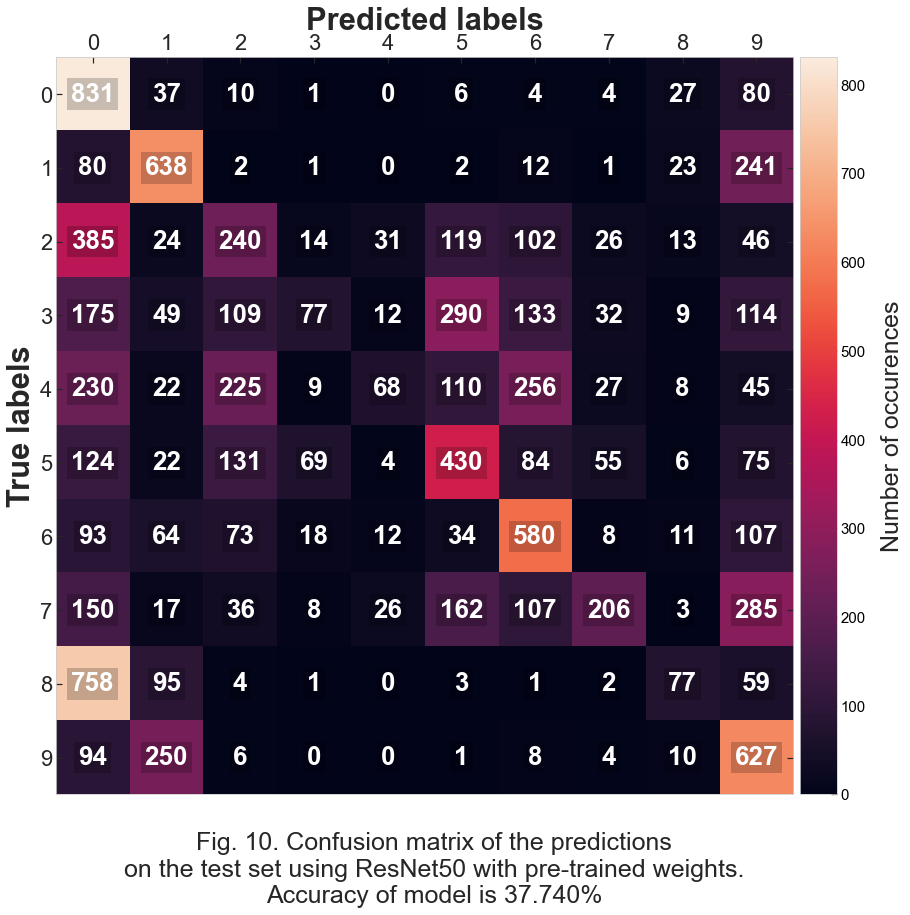

In [205]:
plot_confusion_matrix(conf_mat, y_test_b, labels=[i for i in range(0,10)],
                      title=('Fig. 10. Confusion matrix of the predictions\n' +
                             'on the test set using ResNet50 with pre-trained weights.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))

### 5./d. Train it longer (eg. 100 epochs)

- I also utilized early stopping with 20 epochs patience

In [206]:
with tf.device('/device:GPU:0'):
    # Create checkpoint file to save best model into
    best_model_ex5 = kc.ModelCheckpoint('./models/best_model_ex5.hdf5', save_best_only=True, verbose=1)
    # Configure early stopping with N epochs of patience
    es_ex5 = kc.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # Define the model
    model_ex5 = best_model(imsize=32, n_channels=3, n_class=10,
                           model_name='model_ex5')
    
    # Configure the model
    model_ex5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                      loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0),
                      metrics=['accuracy'])

In [207]:
model_ex5.summary()

Model: "model_ex5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ex5 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
final_dense_ex5 (Dense)      (None, 1, 1, 10)          20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [208]:
epochs_ex5 = 100

In [209]:
with tf.device('/device:GPU:0'):
    history_ex5 = model_ex5.fit(x=X_train,
                                y=y_train,
                                batch_size=32,
                                epochs=epochs_ex5,
                                verbose=1,
                                validation_split=0.2,
                                shuffle=True,
                                callbacks=[es_ex5, best_model_ex5],
                                initial_epoch=0,
                                steps_per_epoch=None)

Epoch 1/100
1250/1250 [==============================] - 98s 72ms/step - loss: 3.0808 - accuracy: 0.1631 - val_loss: 2.4990 - val_accuracy: 0.2331

Epoch 00001: val_loss improved from inf to 2.49903, saving model to ./models\best_model_ex5.hdf5
Epoch 2/100
1250/1250 [==============================] - 89s 71ms/step - loss: 2.3448 - accuracy: 0.2609 - val_loss: 4.0442 - val_accuracy: 0.2879

Epoch 00002: val_loss did not improve from 2.49903
Epoch 3/100
1250/1250 [==============================] - 89s 71ms/step - loss: 1.7605 - accuracy: 0.3645 - val_loss: 2.8400 - val_accuracy: 0.3290

Epoch 00003: val_loss did not improve from 2.49903
Epoch 4/100
1250/1250 [==============================] - 89s 71ms/step - loss: 1.5176 - accuracy: 0.4445 - val_loss: 1.6733 - val_accuracy: 0.4321

Epoch 00004: val_loss improved from 2.49903 to 1.67335, saving model to ./models\best_model_ex5.hdf5
Epoch 5/100
1250/1250 [==============================] - 89s 71ms/step - loss: 1.3322 - accuracy: 0.5232 - v

### 5./e. Evaluate loss and accuracy history of longer run

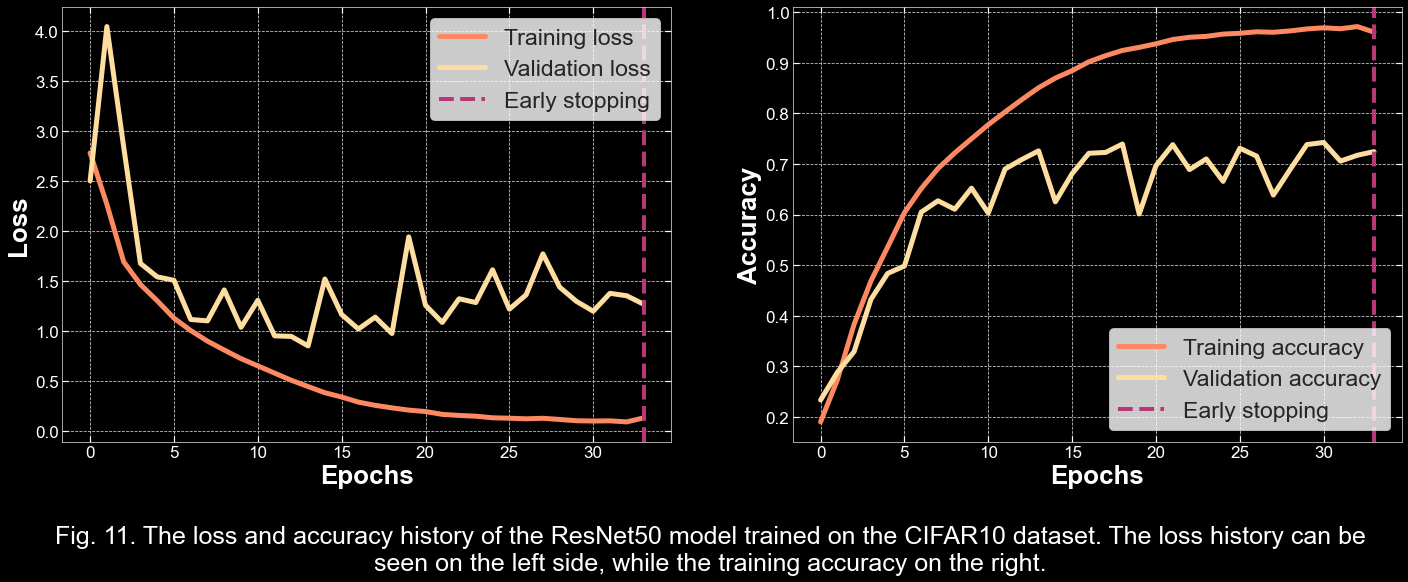

In [210]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*12, nrows*8),
                         facecolor='black', subplot_kw={'facecolor' : 'black'})

# LOSS GRAPH
ax = axes[0]
ax.plot(history_ex5.epoch, history_ex5.history['loss'], label='Training loss',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex5.epoch, history_ex5.history['val_loss'], label='Validation loss',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Loss', fontsize=axislabelsize, fontweight='bold',
              color='white')

# ACCURACY GRAPH
ax = axes[1]
ax.plot(history_ex5.epoch, history_ex5.history['accuracy'], label='Training accuracy',
        c=cm.magma(0.75), lw=5)
ax.plot(history_ex5.epoch, history_ex5.history['val_accuracy'], label='Validation accuracy',
        c=cm.magma(0.93), lw=5)
ax.set_ylabel('Accuracy', fontsize=axislabelsize, fontweight='bold',
              color='white')

for ax in axes.reshape(-1):
    if epochs_ex5 > history_ex5.epoch[-1] : ax.axvline(x=history_ex5.epoch[-1], label='Early stopping',
                                                       color=cm.magma(0.5), ls='--', lw=4)
    ax.set_xlabel('Epochs', fontsize=axislabelsize, fontweight='bold',
                  color='white')
    #ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
    ax.tick_params(axis='both', which='major', labelsize=axisticksize,
                   colors='white')

axes[0].legend(loc='upper right', fontsize=axislegendsize)
axes[1].legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 11. The loss and accuracy history of the ResNet50 model trained on the CIFAR10 dataset. The loss history can be\n' +
             'seen on the left side, while the training accuracy on the right.',
             color='white',
             fontsize=axistitlesize+5, y=-0.02)
    
plt.show()

### 5./f. Make predictions with the more trained model

In [211]:
y_pred = model_ex5.predict(X_test)

In [212]:
# Convert one-hot encoded preds and tests to normal arrays
y_test_b = y_test.reshape(-1, 10)
y_pred_b = y_pred.reshape(-1, 10)
y_test_b = y_test_b.argmax(axis=-1)
y_pred_b = y_pred_b.argmax(axis=-1)

# Calculate and accuracy metric and the confusion matrix
accuracy = accuracy_metric(y_test=y_test_b, y_pred=y_pred_b)
conf_mat = confusion_matrix(y_test_b, y_pred_b, labels=[i for i in range(0,10)])

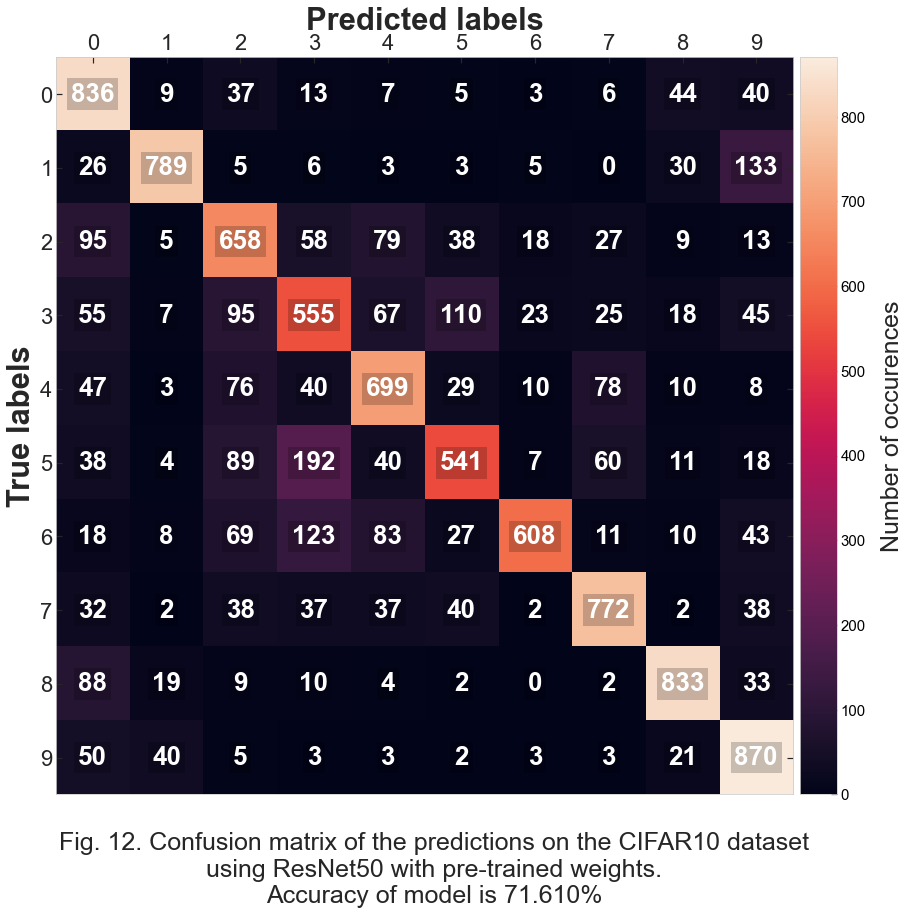

In [213]:
plot_confusion_matrix(conf_mat, y_test_b, labels=[i for i in range(0,10)],
                      title=('Fig. 12. Confusion matrix of the predictions on the CIFAR10 dataset\n' +
                             'using ResNet50 with pre-trained weights.\n' +
                             'Accuracy of model is {0:.3f}%'.format(accuracy)))